In [1]:
import os
import random
import glob
import numpy as np
import pickle as pk
import xarray as xr
import pandas as pd
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import imageio
import scipy.sparse as sparse
import scipy.stats as stats
from multiprocessing import Process, Queue

import torch

import warnings
warnings.filterwarnings('ignore')

In [2]:
# base directory is parent of src/
# base = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) #this is for .py file
base = os.path.abspath(os.path.join(os.getcwd(), '..')) #this is for notebook run
data_dir = os.path.join(base, 'data1')
analysis_dir = os.path.join(base, 'data_analysis')
plots_dir = os.path.join(analysis_dir, 'plots')
statistics_dir = os.path.join(analysis_dir, 'statistics')
"""
os.makedirs(analysis_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)
"""

'\nos.makedirs(analysis_dir, exist_ok=True)\nos.makedirs(plots_dir, exist_ok=True)\n'

In [3]:
"""
Test script: load only first N files per version with xarray + Dask,
skip corrupted files, select correct precipitation variable,
chunk on time only to avoid spatial chunk warnings,
compute basic stats, and save results and plots.

Prerequisites:
    pip install xarray dask netcdf4 matplotlib pandas
"""


def load_dataset_with_dask(data_dir, version, chunks, test_n=2):
    """
    Open only the first `test_n` NetCDF files matching version for quick test, using Dask chunks on time only. 
    Skip if errors occur.
    """
    pattern = os.path.join(data_dir, f"*{version}*.nc")
    all_files = sorted(glob.glob(pattern))

    datasets = []
    count = 0
    for fn in all_files:

        if count >= test_n:
            break

        ds_i = xr.open_dataset(fn, engine='netcdf4', chunks=chunks)

        datasets.append(ds_i)
        count += 1



    ds = xr.concat(datasets, dim='time', combine_attrs='override')
    return ds




In [4]:
def make_gif(data):

    cmap = cm.get_cmap('viridis')
    cmap.set_bad(color=(1.0, 1.0, 1.0)) 
    frames = []

    for day in data.compute().values:

        masked_day = np.ma.masked_invalid(day[::-1])
        norm = Normalize(vmin=masked_day.min(), vmax=masked_day.max())

        rgba = cmap(norm(masked_day))
        frames.append((rgba[:, :, :3] * 255).astype(np.uint8))

    imageio.mimsave('animation.gif', frames)

In [5]:
ds = xr.open_dataset('../data/pr_hyras_1_1952_v6-1_de.nc', engine='netcdf4')
pr_var = ds.variables['pr']
print("Variable shape:", pr_var.shape)
print("Variable dimensions:", pr_var.dims)
print("Chunking info:", pr_var.chunks)

Variable shape: (366, 890, 665)
Variable dimensions: ('time', 'y', 'x')
Chunking info: None


In [ ]:
#make_gif(ds['pr'])

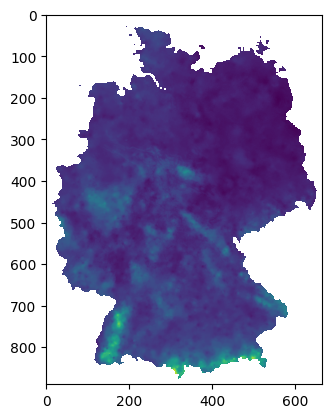

In [73]:
plt.imshow(ds['pr'].mean(dim=['time']).compute().values[::-1])
plt.show()

In [5]:
chunks = {'time': 100}
version = 'v6-1'

ds = load_dataset_with_dask(data_dir, version, chunks, test_n=10)

In [ ]:
"""with open(f'{statistics_dir}\global_mean.pkl', 'wb') as file:
    pk.dump(data, file)"""

In [180]:
with open(f'{statistics_dir}\global_mean.pkl', 'rb') as file:
    data_global = pk.load(file)

In [6]:
data = ds['pr'][:, 400:420, 400:420].compute().values.flatten()

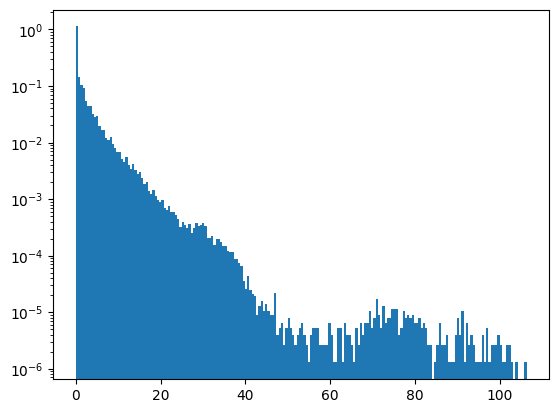

In [8]:
bins = plt.hist(data, bins=200, density=True, log=True)
plt.show()

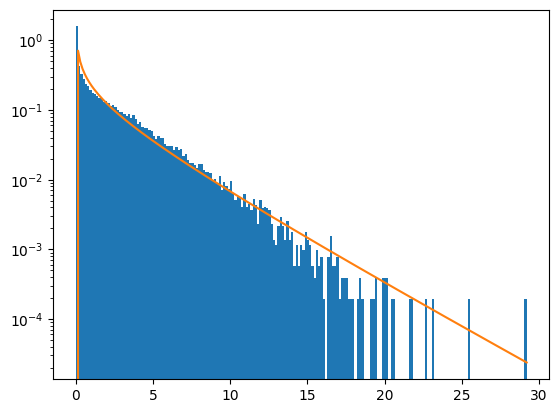

In [ ]:
"""
global mean log + gamma fit
"""
data = data_global
c, loc, scale = stats.gamma.fit(data[data != 0])
x = np.linspace(np.min(data), np.max(data), 200)

plt.hist(data, bins=x, density=True, log=True)
plt.plot(x, stats.gamma.pdf(x, c, loc, scale))
plt.show()

In [160]:
data_whole = ds['pr'][:,500,300].compute().values

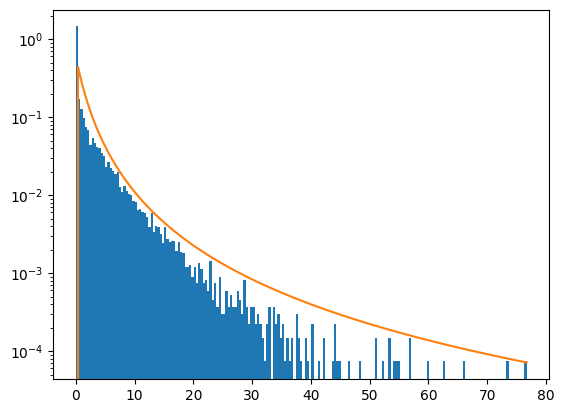

In [ ]:
"""
random area log + pareto fit
"""
data = data_whole
c, loc, scale = stats.pareto.fit(data[data != 0])
x = np.linspace(np.min(data), np.max(data), 200)

plt.hist(data, bins=x, density=True, log=True)
plt.plot(x, stats.pareto.pdf(x, c, loc, scale))
plt.show()

In [194]:
data = data_global[:365*10]

In [196]:
c, loc, scale

(0.5358663863010648, 5.807200234011081e-06, 3.7754725538045264)

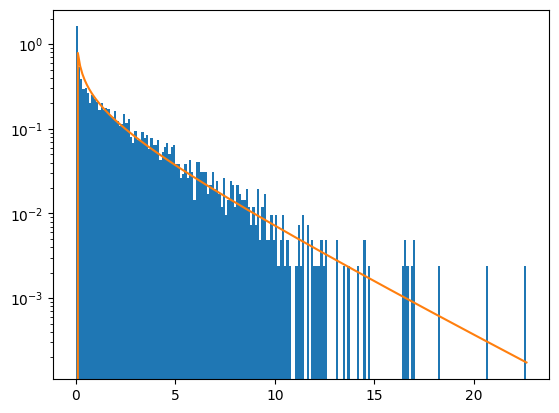

In [195]:
"""
random area log + pareto fit
"""
c, loc, scale = stats.gamma.fit(data[data != 0])
x = np.linspace(np.min(data), np.max(data), 200)

plt.hist(data, bins=x, density=True, log=True)
plt.plot(x, stats.gamma.pdf(x, c, loc, scale))
plt.show()

In [191]:
data = data_global[-365*10:]

In [193]:
c, loc, scale

(0.41426522052375714, 1.1061333942585425e-06, 5.056850691504353)

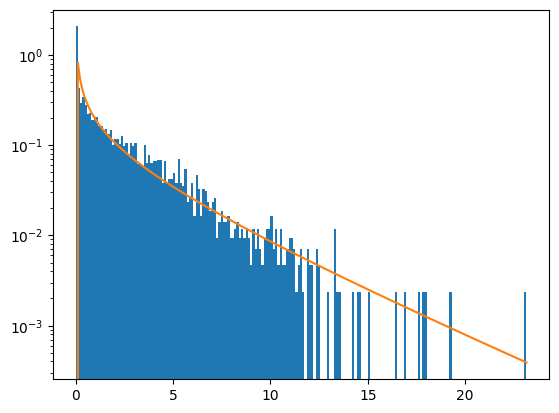

In [192]:
"""
random area log + pareto fit
"""
c, loc, scale = stats.gamma.fit(data[data != 0])
x = np.linspace(np.min(data), np.max(data), 200)

plt.hist(data, bins=x, density=True, log=True)
plt.plot(x, stats.gamma.pdf(x, c, loc, scale))
plt.show()